In [1]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import os
import cv2
import random
import shutil
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image

In [3]:
#경로 지정
train_dir = 'data/Training'
test_dir = 'data/Testing'

In [4]:
#레이블 값 (classes)
classes = os.listdir(train_dir)
print(classes)

['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']


In [5]:
#VGG-16, vit (전처리)
resize_size = 256
crop_size = 224

def preprocess_image(image):
    image = tf.image.resize(image, [resize_size, resize_size], method=tf.image.ResizeMethod.BILINEAR) #크기 조절
    image = tf.image.central_crop(image, central_fraction=crop_size / resize_size) #중앙 224x224
    image = tf.math.divide(image, 255.0) #normalize
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std #다 normalize

    return image

In [6]:
from sklearn.preprocessing import LabelEncoder

X = [] #Image
y = [] #class
for i in classes:
    folderPath = os.path.join(train_dir,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j)) #이미지 읽기
        img = preprocess_image(img) #전처리
        X.append(img) #X list 넣고
        y.append(i) # y list
X = np.array(X)
y = np.array(y)
y = tf.keras.utils.to_categorical([classes.index(label) for label in y]) #문자열 -> [0,3]

  0%|                                           | 1/395 [00:00<00:52,  7.52it/s]

Metal device set to: Apple M2 Pro


100%|████████████████████████████████████████| 827/827 [00:03<00:00, 220.54it/s]


In [33]:
X_train, xx, y_train, yy = train_test_split(X,y, test_size=0.2, random_state=42) #training 분할 (train,val)
X_train, X_val, y_train, y_val = train_test_split(xx,yy, test_size=0.5, random_state=42) #training 분할 (train,val)

In [34]:
X_test = []
y_test = []
for i in classes:
    folderPath = os.path.join(test_dir,i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = preprocess_image(img)
        X_test.append(img)
        y_test.append(i)
X_test = np.array(X_test)
y_test = np.array(y_test)
y_test = tf.keras.utils.to_categorical([classes.index(label) for label in y_test]) #testing -> testset

100%|██████████████████████████████████████████| 74/74 [00:00<00:00, 170.68it/s]


In [35]:
#data augmentation 아직 적용 안햇음.
#augmentation은 어떻게 하면 좋을지..? -> 고민해주시면 좋을 것 같습니다...... 코드 짜서 주시면 좋을거같습니당....
# img_datagen = ImageDataGenerator(
#     rotation_range=30,
#     rescale = 1./255.,
#     width_shift_range = 0.3,
#     height_shift_range = 0.3,
#     shear_range = 0.3,
#     zoom_range = 0.3,
#     horizontal_flip = True,
#     vertical_flip = True)

# img_datagen.fit(X_train)

In [36]:
#그래프 그려주는 거 (성능 그래프)
def plot_acc_model(acc, val_acc, epochs):
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
    plt.show()
    
def plot_loss_model(loss, val_loss, epochs):
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend(loc=0)
    plt.figure()
    plt.show()

In [37]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

In [38]:
#VGG16, imagenet에 대해서 사전학습된거, 224x224 -> Input, layer.trainable -> 사전학습된 모델이어서 처음에는 가중치 false 학습이 안되어서
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

In [39]:
x = Flatten()(base_model.output)
#class가 4개라서
output = Dense(4, activation='softmax')(x)

In [40]:
#파라미터 튜닝 : learning_rate 부분 값 수정, optimizer -> 다른 optimizer 사용, loss = 다른 loss 사용.
model = Model(inputs=base_model.input, outputs=output)
optimizer=tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

                                                                                                  
 conv2_block3_preact_relu (Acti  (None, 56, 56, 256)  0          ['conv2_block3_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16384       ['conv2_block3_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_blo

 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block2_2_pad[0][0]']     
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block5_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block5_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block5_2_pad (ZeroPaddin  (None, 30, 30, 128)  0          ['conv3_block5_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv3_blo

                                                                  'conv3_block7_3_conv[0][0]']    
                                                                                                  
 conv3_block8_preact_bn (BatchN  (None, 28, 28, 512)  2048       ['conv3_block7_out[0][0]']       
 ormalization)                                                                                    
                                                                                                  
 conv3_block8_preact_relu (Acti  (None, 28, 28, 512)  0          ['conv3_block8_preact_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 conv3_block8_1_conv (Conv2D)   (None, 28, 28, 128)  65536       ['conv3_block8_preact_relu[0][0]'
                                                                 ]                                
          

 n)                                                                                               
                                                                                                  
 conv4_block2_2_pad (ZeroPaddin  (None, 16, 16, 256)  0          ['conv4_block2_1_relu[0][0]']    
 g2D)                                                                                             
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  589824      ['conv4_block2_2_pad[0][0]']     
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_blo

 conv4_block5_preact_bn (BatchN  (None, 14, 14, 1024  4096       ['conv4_block4_out[0][0]']       
 ormalization)                  )                                                                 
                                                                                                  
 conv4_block5_preact_relu (Acti  (None, 14, 14, 1024  0          ['conv4_block5_preact_bn[0][0]'] 
 vation)                        )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262144      ['conv4_block5_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block7_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block7_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block7_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block7_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_blo

 conv4_block10_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block10_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block10_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block10_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block10_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block10_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block10_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block10_1_relu[0][0]']   
 ng2D)    

                                                                                                  
 conv4_block12_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block12_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block12_out (Add)        (None, 14, 14, 1024  0           ['conv4_block11_out[0][0]',      
                                )                                 'conv4_block12_3_conv[0][0]']   
                                                                                                  
 conv4_block13_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block12_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_blo

 conv4_block15_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block15_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block15_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block15_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block15_2_pad[0][0]']    
                                                                                                  
 conv4_block15_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block15_2_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block18_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block17_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block18_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block18_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block18_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block18_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_blo

 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block20_2_pad[0][0]']    
                                                                                                  
 conv4_block20_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block20_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block20_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block20_2_relu[0][0]']   
                                )                                                                 
          

                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block23_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block23_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block23_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 on)                                                                                              
                                                                                                  
 conv4_block25_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block25_2_relu[0][0]']   
                                )                                                                 
                                                                                                  
 conv4_block25_out (Add)        (None, 14, 14, 1024  0           ['conv4_block24_out[0][0]',      
                                )                                 'conv4_block25_3_conv[0][0]']   
                                                                                                  
 conv4_block26_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block25_out[0][0]']      
 Normalization)                 )                                                                 
          

                                                                                                  
 conv4_block28_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block28_2_pad (ZeroPaddi  (None, 16, 16, 256)  0          ['conv4_block28_1_relu[0][0]']   
 ng2D)                                                                                            
                                                                                                  
 conv4_block28_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block28_2_pad[0][0]']    
                                                                                                  
 conv4_block28_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block28_2_conv[0][0]']   
 lization)

                                )                                 'conv4_block30_3_conv[0][0]']   
                                                                                                  
 conv4_block31_preact_bn (Batch  (None, 14, 14, 1024  4096       ['conv4_block30_out[0][0]']      
 Normalization)                 )                                                                 
                                                                                                  
 conv4_block31_preact_relu (Act  (None, 14, 14, 1024  0          ['conv4_block31_preact_bn[0][0]']
 ivation)                       )                                                                 
                                                                                                  
 conv4_block31_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block31_preact_relu[0][0]
                                                                 ']                               
          

                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 256)  589824      ['conv4_block33_2_pad[0][0]']    
                                                                                                  
 conv4_block33_2_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block33_2_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_2_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block33_2_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_3_conv (Conv2D)  (None, 14, 14, 1024  263168      ['conv4_block33_2_relu[0][0]']   
          

 ivation)                       )                                                                 
                                                                                                  
 conv4_block36_1_conv (Conv2D)  (None, 14, 14, 256)  262144      ['conv4_block36_preact_relu[0][0]
                                                                 ']                               
                                                                                                  
 conv4_block36_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block36_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block36_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block36_1_bn[0][0]']     
 on)                                                                                              
          

 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_out (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_conv[0][0]']    
          

In [42]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 100

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Define model checkpoint to save the best model
checkpoint = ModelCheckpoint("resnet_epochs_"+str(epochs)+".h5", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Training the model
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/100
81/81 [==============================] - ETA: 0s - loss: 39.7596 - accuracy: 0.5215
Epoch 1: val_loss improved from inf to 38.77386, saving model to resnet_epochs_100.h5
81/81 [==============================] - 55s 562ms/step - loss: 39.7596 - accuracy: 0.5215 - val_loss: 38.7739 - val_accuracy: 0.4321
Epoch 2/100
81/81 [==============================] - ETA: 0s - loss: 22.2255 - accuracy: 0.6852
Epoch 2: val_loss improved from 38.77386 to 12.69513, saving model to resnet_epochs_100.h5
81/81 [==============================] - 33s 403ms/step - loss: 22.2255 - accuracy: 0.6852 - val_loss: 12.6951 - val_accuracy: 0.7038
Epoch 3/100
81/81 [==============================] - ETA: 0s - loss: 16.5378 - accuracy: 0.7398
Epoch 3: val_loss did not improve from 12.69513
81/81 [==============================] - 30s 361ms/step - loss: 16.5378 - accuracy: 0.7398 - val_loss: 25.8808 - val_accuracy: 0.6272
Epoch 4/100
81/81 [==============================] - ETA: 0s - loss: 7.6577 - accurac

In [25]:
#학습 성능 확인
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

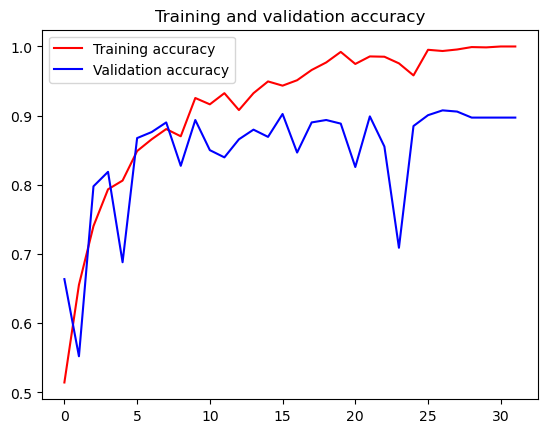

<Figure size 640x480 with 0 Axes>

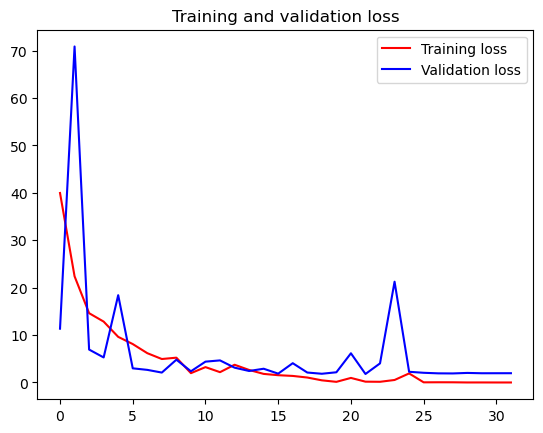

<Figure size 640x480 with 0 Axes>

In [26]:
#학습 성능 그래프화
plot_acc_model(acc, val_acc, epochs)
plot_loss_model(loss, val_loss, epochs)

In [29]:
from sklearn.metrics import classification_report,accuracy_score

best_model = keras.models.load_model("resnet_epochs_100.h5")
y_pred = best_model.predict(X_test)
y_pred_single_label = np.argmax(y_pred, axis=1)
y_test_single_label = np.argmax(y_test, axis=1)
from sklearn.metrics import classification_report,accuracy_score

class_report = classification_report(y_test_single_label, y_pred_single_label, zero_division=1)
print(class_report)

13/13 [==============================] - 9s 478ms/step
              precision    recall  f1-score   support

           0       0.67      0.99      0.80       105
           1       0.73      0.93      0.82       115
           2       0.90      0.19      0.31       100
           3       0.90      0.86      0.88        74

    accuracy                           0.75       394
   macro avg       0.80      0.74      0.70       394
weighted avg       0.79      0.75      0.70       394



  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 59ms/step


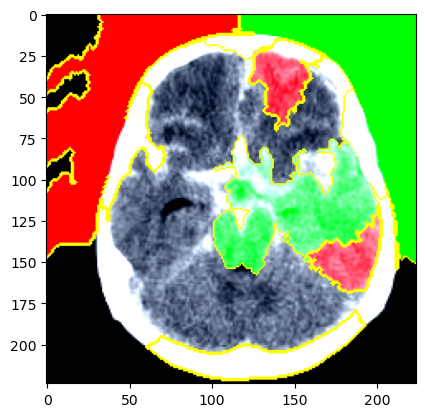

In [30]:
from lime.lime_image import LimeImageExplainer
import matplotlib.pyplot as plt

#예측된 결과중 첫번째 (X_test[0])에다가 LIME(설명가능한 인공지능 기법) 붙이기
explainer = LimeImageExplainer()
image_to_explain = X_test[0]
explanation = explainer.explain_instance(X_test[0].astype('double'), best_model.predict, top_labels=1, hide_color=0, num_samples=1000)

#mask에서 positive_only = True로 하면 긍정적으로 예측에 기여하는 부분만 시각화
#False -> 부정적으로 기여하는 부분도 시각화
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

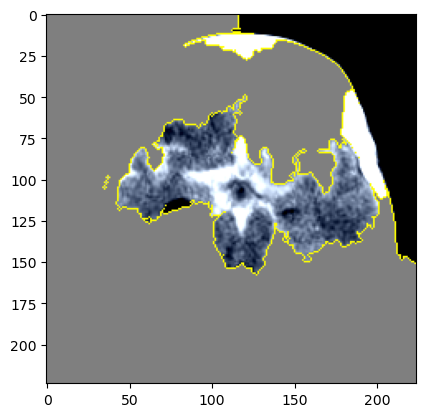

In [31]:
#긍정적으로 기여하는 부분 (슈퍼픽셀)만 시각화
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  25%|█████▊                 | 1/4 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████████▎   | 3/4 [00:27<00:06,  6.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|███████████████| 4/4 [00:43<00:00, 10.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 5it [00:59, 14.84s/it]                            


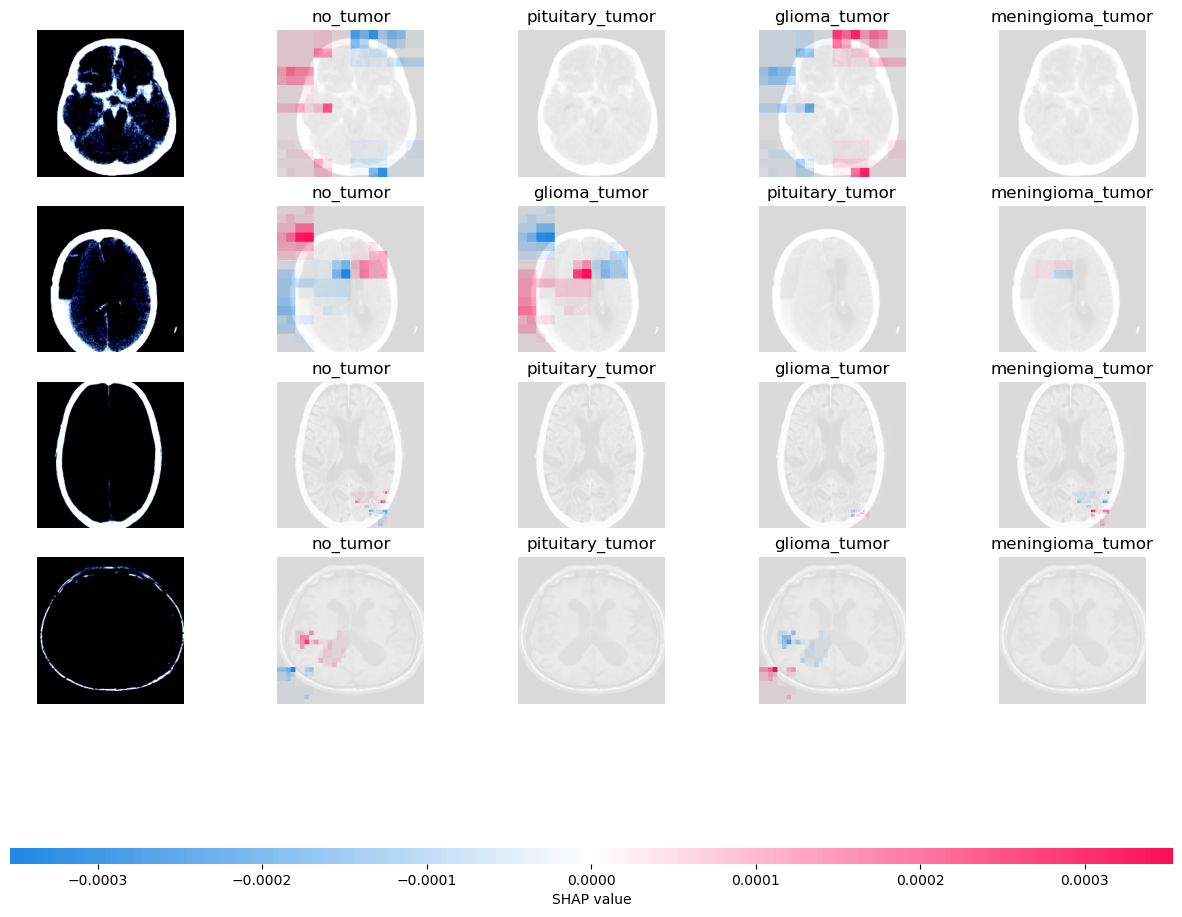

In [32]:
import shap

#shap도 비슷 (빨간색 : 긍정적, 파란색: 부정적)
shap.initjs()
masker = shap.maskers.Image("inpaint_telea", X_test[0].shape)
explainer = shap.Explainer(best_model, masker, output_names=classes)
explainer
shap_values = explainer(X_test[:4], outputs=shap.Explanation.argsort.flip[:5])
shap_values.shape
shap.image_plot(shap_values)